### Spark Version
Based on file 'Fannie Mae Analysis (Big Data) - JC V2 - EMR Version (test 3).ipynb'

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import itertools
import datetime
import matplotlib.pyplot as plt
from pylab import rc, rcParams

In [2]:
from pyspark.sql import SparkSession # Remove for Databricks
from pyspark.sql.types import *      # Import Data Types
from pyspark.sql.functions import isnan, when, count, sum, col, max as smax, avg, round, to_date, year, trunc, quarter, lower, udf, lag
from pyspark.sql.window import Window # For defining windows for window functions

from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, OneHotEncoderEstimator, Imputer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.mllib.linalg import Vectors, DenseMatrix

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score

%matplotlib inline
#from sklearn.ensemble import RandomForestClassifier

In [6]:
import os
os.getcwd()

'/home/jchuyunqiang/ml_projects/pandas-sk-learn-bank-loan-ml'

In [7]:
# Set Pandas view options as needed

pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 400)

#pd.set_option('display.height', 1000)
#pd.set_option('display.width', 1000)

In [8]:
# Testing increased memory
from pyspark.conf import SparkConf

conf = SparkConf().setAll([('spark.driver.memory', '10g'), 
#                             ('spark.executor.cores', '4'),
#                             ("spark.executor.instances", '2'),
                            ("spark.default.parallelism", '4'),
                            ("spark.sql.shuffle.partitions", 32),
                            ("spark.master", 'local[8]')])
                            #('spark.cores.max', '4'), 
                            #('spark.driver.memory','1g')])

spark = SparkSession.builder.appName("fannie_spark_app").config(conf=conf).getOrCreate() 
sc = spark.sparkContext
print('Session Created')

Session Created


In [10]:
# Important parameters to consider for Spark tuning
# DOES NOT SEEM TO WORK DURING RUNNING TIME

# For 5 m4.2xlarge instances

# Set equal to number of cores on an executor
# spark.conf.set("spark.executor.cores", '2') 

# Set equal to 85% of total node memory to account for overheads (if executors more than nodes, need to adjust)
# spark.conf.set("spark.executor.memory", '5g')

# Set equal to number of worker nodes (does not necessarily have to be like this)
# spark.conf.set("spark.executor.instances", '20')

# Set to multiple of 2 to 3 of executor instances
# spark.conf.set("spark.default.parallelism", '40')

# Set to multiple of 2 to 3 of executor instances
# spark.conf.set("spark.yarn.executor.memoryOverhead", '1g')

# Set default shuffle partitions
# spark.conf.set("spark.sql.shuffle.partitions", 80)

# sparkConf.set("spark.sql.tungsten.enabled", "true")
# sparkConf.set("spark.io.compression.codec", "snappy")

In [11]:
#spark.stop()

In [9]:
spark

In [13]:
sc.getConf().getAll()

[('spark.app.name', 'fannie_spark_app'),
 ('spark.driver.port', '51964'),
 ('spark.driver.host', '192.168.0.10'),
 ('spark.rdd.compress', 'True'),
 ('spark.master', 'local[8]'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.memory', '10g'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.default.parallelism', '4'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.sql.shuffle.partitions', '32'),
 ('spark.app.id', 'local-1574043133510')]

# Official Start (Cleaned up code)

In [14]:
# Start time
print('Start time: ',datetime.datetime.now())

Start time:  2019-11-17 21:14:16.161559


In [15]:
# Custom Schema for Acquisition DataFrame

acq_schema = StructType([
    StructField('id_A', LongType()),
    StructField('orig_channel_A', StringType()),
    StructField('seller_name_A', StringType()),
    StructField('orig_int_rate_A', FloatType()),
    StructField('orig_upb_A', FloatType()),
    StructField('orig_loan_term_A', FloatType()),
    StructField('orig_date_A', StringType()), 
    StructField('first_pay_date_A', StringType()),
    StructField('orig_ltv_A', FloatType()),
    StructField('orig_cltv_A', FloatType()),
    StructField('borrowers_A', FloatType()),
    StructField('orig_dtir_A', FloatType()),
    StructField('borrower_credit_score_A', FloatType()),
    StructField('first_time_buyer_A', StringType()),
    StructField('purpose_A', StringType()),
    StructField('property_type_A', StringType()),
    StructField('num_of_units_A', FloatType()),
    StructField('occupancy_type_A', StringType()),
    StructField('state_A', StringType()),
    StructField('zip_A', StringType()),
    StructField('insurance_perc_A', FloatType()),
    StructField('product_type_A', StringType()),
    StructField('co_borrower_credit_score_A', FloatType()),
    StructField('insurance_type_A', FloatType()),
    StructField('relocation_A', StringType())
])

print('Number of columns:', len(acq_schema))

Number of columns: 25


In [17]:
# Testing using EMR to load from S3 directly

# Load acquisition data

acq_df = (spark.read
          .format('csv')
          .schema(acq_schema)
          .load('/mnt/c/from_laptop/machine_learning_projects/Fannie Mae/Acquisition_All/Acquisition_2007Q4.txt'
                ,sep='|'))
          # USE BELOW FOR DATABRICKS
          #.load('/mnt/fannie_mae/unzipped/Acquisition_All/Acquisition_2007Q1.txt', sep='|'))

In [19]:
acq_df.count()

391209

In [17]:
# Custom Schema for Performance DataFrame

perf_schema = StructType([
    StructField("id", LongType()),
    StructField('rep_period', StringType()),
    StructField('servicer', StringType()),
    StructField('curr_int_rate', FloatType()),
    StructField('curr_act_upb', FloatType()),
    StructField('loan_age', IntegerType()),
    StructField('remaining_months_legal', FloatType()),
    StructField('adjusted_months_legal', FloatType()),
    StructField('maturity_date', StringType()),
    StructField('MSA', StringType()),
    StructField('current_loan_stat', StringType()),
    StructField('mod_flag', StringType()),
    StructField('zero_bal_code', StringType()),
    StructField('zero_bal_date', StringType()),
    StructField('last_paid_date', StringType()),
    StructField('foreclosure_date', StringType()),
    StructField('disposition_date', StringType()),
    StructField('foreclosure_cost', FloatType()),
    StructField('preservation_costs', FloatType()),
    StructField('recovery_costs', FloatType()),
    StructField('holding_expenses_and_credits', FloatType()),
    StructField('holding_tax', FloatType()),
    StructField('net_sale_proceeds', FloatType()),
    StructField('credit_enhance_proceeds', FloatType()),
    StructField('make_whole_proceeds', FloatType()),
    StructField('other_proceeds', FloatType()),
    StructField('non_int_bearing_upd', FloatType()), 
    StructField('principal_forgiveness_amount', FloatType()),
    StructField('make_whole_proceeds_flag', StringType()),
    StructField('foreclosure_principal_write_off', FloatType()),
    StructField('servicing_activity_indicator', StringType())
])

In [18]:
# Load data using Spark

perf_df = (spark.read
           .format('csv')
           .schema(perf_schema)
           .load('/mnt/d/users/machine_learning_projects/Fannie Mae/2007Q4/Performance_2007Q4.txt', 
                 sep='|'))

In [19]:
# Create view to be able to use SQL

perf_df.createOrReplaceTempView("fannie")

# Filter out those rows that have 'X'

perf_df = spark.sql("SELECT * FROM fannie WHERE (current_loan_stat NOT IN ('X')) AND (current_loan_stat IS NOT NULL)")

In [20]:
# Convert monthly_rep_period to date format (actual format mm/dd/YYYY)

perf_df = perf_df.withColumn('rep_period',to_date(col('rep_period'),"MM/dd/yyyy"))

# Drop unneeded columns

perf_df = perf_df.drop('servicer','non_int_bearing_upd','principal_forgiveness_amount',
                                'maturity_date','zero_bal_date','last_paid_date',
                                'foreclosure_date','disposition_date','foreclosure_cost',
                                'preservation_costs','recovery_costs',
                                'holding_expenses_and_credits','holding_tax','net_sale_proceeds',
                                'credit_enhance_proceeds','make_whole_proceeds',
                                'other_proceeds','make_whole_proceeds_flag',
                                'foreclosure_principal_write_off')

# Create year and quarter column from 'monthly_rep_period'

perf_df = perf_df.select("*",year(col('rep_period')).alias('rep_period_year'),
               quarter(col('rep_period')).alias('rep_period_quarter'))

In [21]:
# Check converted to date

perf_df.printSchema()

root
 |-- id: long (nullable = true)
 |-- rep_period: date (nullable = true)
 |-- curr_int_rate: float (nullable = true)
 |-- curr_act_upb: float (nullable = true)
 |-- loan_age: integer (nullable = true)
 |-- remaining_months_legal: float (nullable = true)
 |-- adjusted_months_legal: float (nullable = true)
 |-- MSA: string (nullable = true)
 |-- current_loan_stat: string (nullable = true)
 |-- mod_flag: string (nullable = true)
 |-- zero_bal_code: string (nullable = true)
 |-- servicing_activity_indicator: string (nullable = true)
 |-- rep_period_year: integer (nullable = true)
 |-- rep_period_quarter: integer (nullable = true)



In [22]:
# Load FHFA data for housing price indices
# Source: https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qpo

fhfa_df = pd.read_excel("/mnt/d/Users/machine_learning_projects/Fannie Mae/FHFA/HPI_PO_metro.xls")
fhfa_df = fhfa_df.drop(columns=['metro_name','index_nsa'])

fhfa_schema = StructType([
    StructField("cbsa", IntegerType()),
    StructField('yr', IntegerType()),
    StructField('qtr', IntegerType()),
    StructField('index_sa', FloatType())
])

fhfa_df = (spark.createDataFrame(fhfa_df, fhfa_schema))
fhfa_df.printSchema()

root
 |-- cbsa: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- qtr: integer (nullable = true)
 |-- index_sa: float (nullable = true)



In [23]:
# Calculate difference in adjusted and remaining months
# This is to see if some prepayment done

perf_df = (perf_df.select("*",(col('adjusted_months_legal')-col('remaining_months_legal')).alias('diff_months')))
perf_df = perf_df.drop('rep_period','curr_act_upb')

#perf_df = perf_df.drop('adjusted_months_legal','remaining_months_legal')

In [24]:
# Merging of perf_df and fhfa_df (MSA version)

perf_fhfa_df = perf_df.join(fhfa_df,
              (perf_df.MSA == fhfa_df.cbsa) & (perf_df.rep_period_year == fhfa_df.yr) & 
              (perf_df.rep_period_quarter == fhfa_df.qtr),
               how='left').drop('cbsa','yr','qtr')

In [25]:
# Load FHFA data for housing price indices (State version)
# Some MSA are not covered so need to use state to fill
# Source: https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx#qpo

fhfa_state_df = pd.read_excel("/mnt/d/Users/machine_learning_projects/Fannie Mae/FHFA/HPI_PO_state.xls")
fhfa_state_df = fhfa_state_df.drop(columns=['index_nsa','Warning'])

fhfa_state_schema = StructType([
    StructField("state", StringType()),
    StructField('yr', IntegerType()),
    StructField('qtr', IntegerType()),
    StructField('index_sa_state', FloatType())
])

fhfa_state_df = (spark.createDataFrame(fhfa_state_df, fhfa_state_schema))
fhfa_state_df.printSchema()

root
 |-- state: string (nullable = true)
 |-- yr: integer (nullable = true)
 |-- qtr: integer (nullable = true)
 |-- index_sa_state: float (nullable = true)



In [26]:
# Merge state from acquisition with performance data

perf_fhfa_df = perf_fhfa_df.join(acq_df.select('id_A','state_A'),
              (perf_fhfa_df.id == acq_df.id_A),
               how='inner').drop('id_A')

In [27]:
# Now to join with FHFA file (State)

perf_fhfa_df = perf_fhfa_df.join(fhfa_state_df,(perf_fhfa_df.state_A==fhfa_state_df.state) 
                  & (perf_fhfa_df.rep_period_year==fhfa_state_df.yr) 
                  & (perf_fhfa_df.rep_period_quarter==fhfa_state_df.qtr),how='left')


In [28]:
# Formula for selecting index_sa vs index_sa_state (None equals Null in Spark)

def index_selector(index_sa,index_sa_state):
    if index_sa == None:
        if index_sa_state == None:
            value = 0
        else:
            value = index_sa_state
    else:
        value = index_sa
    return float(value) # Need float otherwise gives all nulls

index_selector_udf = udf(index_selector,FloatType())

# Apply formula
perf_fhfa_df = (perf_fhfa_df
                .withColumn('housing_index',index_selector_udf(col('index_sa'),col('index_sa_state')))
                .drop('index_sa','state','yr','qtr','index_sa_state'))

In [29]:
# Join with acq_df to get 'A_original_loan_to_value'

perf_fhfa_df = (perf_fhfa_df
                .join(acq_df.select('id_A','orig_ltv_A'),perf_fhfa_df.id==acq_df.id_A,how='inner')
                .drop('id_A'))

In [30]:
# Determine percentage change in housing index using window function

# Create a window spec.
wSpec1 = Window.partitionBy("id").orderBy('loan_age')

# Calculate the difference in percentage of housing_index
perf_fhfa_df = perf_fhfa_df.withColumn("housing_pdiff", (col("housing_index") - lag("housing_index",1).over(wSpec1))
                        /lag("housing_index",1).over(wSpec1))

In [31]:
# Fill NA in 'loan_group_diff' with 1 as the base house index for each loan_id

perf_fhfa_df = perf_fhfa_df.na.fill(float(1),"housing_pdiff")

# Calculate cumulative sum of 'loan_group_diff'

wSpec2 = Window.partitionBy("id").orderBy("loan_age")

perf_fhfa_df = (perf_fhfa_df.withColumn("cum_house_index", sum("housing_pdiff").over(wSpec2)))

# Calculate current ltv

perf_fhfa_df = perf_fhfa_df.withColumn("curr_ltv",col("orig_ltv_A")/col("cum_house_index"))

# Calculate percentage difference in current ltv from original ltv

perf_fhfa_df = perf_fhfa_df.withColumn("curr_ltv_perc_diff",(col("curr_ltv")-col("orig_ltv_A"))/(col("orig_ltv_A")))

# This is how final perf_df should look like before joining with acq_df

perf_fhfa_df = perf_fhfa_df.drop('state_A','orig_ltv_A','housing_pdiff','cum_house_index',
                                 'housing_index','curr_ltv')

In [32]:
# With all nulls removed, we can now define the conversion function
# To convert current_loan_delinquency_stat to a binary classification problem

# Basel II defines default as 90 days or over without payment
# Thus, we choose anything with delinquency status of 3 and above as defaulted

def delin_marker(current_loan_stat):
    if current_loan_stat in ['0','1','2']:
        return '0'
    else:
        return '1'
    
delin_marker_udf = udf(delin_marker,StringType())

# Apply formula
perf_fhfa_df = (perf_fhfa_df.withColumn('mapped_loan_stat',
                                        delin_marker_udf(col('current_loan_stat')).astype(IntegerType())))

# Take only diff_months from the ones that have '0' as current_loan_stat

diff_month_udf = udf(lambda diff_months,mapped_loan_stat: diff_months if mapped_loan_stat == 0 else 0)

perf_fhfa_df = perf_fhfa_df.withColumn('diff_months_pre',
                        diff_month_udf(col('diff_months'),col('mapped_loan_stat')))

In [33]:
# Convert 'MSA' to integer and 'diff_months_pre' to float

perf_fhfa_df = (perf_fhfa_df.withColumn('diff_months_pre',col('diff_months_pre').astype(FloatType()))
                            .withColumn('MSA',col('MSA').astype(IntegerType())))

# Convert 'mod_flag' to integer

def mod_flag(mod_flag):
    if mod_flag == 'N':
        return 0
    else:
        return 1

mod_flag_udf = udf(mod_flag,IntegerType())

perf_fhfa_df = perf_fhfa_df.withColumn('mod_flag',mod_flag_udf(col('mod_flag')))

# Convert 'servicing_activity_indicator' to integer

def serv_act(servicing_activity_indicator):
    if servicing_activity_indicator == 'Y':
        return 1
    else:
        return 0

serv_act_udf = udf(serv_act,IntegerType())

perf_fhfa_df = (perf_fhfa_df.withColumn('servicing_activity_indicator',
                                        serv_act_udf(col('servicing_activity_indicator'))))

In [34]:
# Group by loan_id and aggregate

perf_fhfa_df = (perf_fhfa_df.groupBy('id').agg(avg(col('curr_int_rate')).alias('avg_curr_int_rate'),
                                smax(col('curr_int_rate')).alias('max_curr_int_rate'),
                                avg(col('loan_age')).alias('mean_loan_age'),
                                smax(col('MSA')).alias('max_MSA'),
                                smax(col('mapped_loan_stat')).alias('max_loan_stat'),
                                avg(col('diff_months_pre')).alias('mean_diff_months_pre'),
                                smax(col('curr_ltv_perc_diff')).alias('max_curr_ltv_perc_diff'),
                                smax(col('mod_flag')).alias('max_mod_flag'),
                                smax(col('servicing_activity_indicator')).alias('max_servicing_activity_indicator') 
                               ))

In [35]:
# Merging (joining) of both perf_df and acq_df

joined_df = perf_fhfa_df.join(acq_df,perf_fhfa_df.id == acq_df.id_A,how='inner').cache()

In [36]:
print(joined_df.count())
joined_df.limit(100).toPandas()

391148


,id,avg_curr_int_rate,max_curr_int_rate,mean_loan_age,max_MSA,max_loan_stat,mean_diff_months_pre,max_curr_ltv_perc_diff,max_mod_flag,max_servicing_activity_indicator,id_A,orig_channel_A,seller_name_A,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_date_A,first_pay_date_A,orig_ltv_A,orig_cltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,first_time_buyer_A,purpose_A,property_type_A,num_of_units_A,occupancy_type_A,state_A,zip_A,insurance_perc_A,product_type_A,co_borrower_credit_score_A,insurance_type_A,relocation_A
0,100057662068,6.625000,6.625,30.5,42660,1,-0.290323,0.441180,0,0,100057662068,R,OTHER,6.625,372000.0,360.0,09/2007,11/2007,49.0,49.0,2.0,21.0,647.0,N,C,SF,1.0,P,WA,981,NaN,FRM,673.0,NaN,N
1,100225167519,6.250000,6.250,28.0,16980,1,0.033898,0.309831,0,0,100225167519,R,"BANK OF AMERICA, N.A.",6.250,193000.0,360.0,12/2007,02/2008,95.0,95.0,1.0,52.0,671.0,N,R,CO,1.0,P,IL,601,30.0,FRM,NaN,1.0,N
2,100752933552,4.734649,6.625,28.0,33460,1,0.071429,0.349183,1,0,100752933552,R,"WELLS FARGO BANK, N.A.",6.625,366000.0,360.0,09/2007,11/2007,80.0,80.0,1.0,43.0,602.0,Y,P,SF,1.0,P,MN,553,NaN,FRM,NaN,NaN,N
3,100758627377,6.250000,6.250,8.0,47260,0,0.000000,0.109803,0,0,100758627377,C,"BANK OF AMERICA, N.A.",6.250,105000.0,360.0,10/2007,12/2007,34.0,34.0,1.0,52.0,756.0,N,C,SF,1.0,P,VA,231,NaN,FRM,NaN,NaN,N
4,100771918637,3.460870,6.500,58.0,31100,0,-2.964286,0.707445,1,0,100771918637,R,"CITIMORTGAGE, INC.",6.500,270000.0,360.0,10/2007,12/2007,58.0,58.0,1.0,49.0,582.0,N,C,SF,1.0,P,CA,902,NaN,FRM,NaN,NaN,N
5,100773508188,6.500000,6.500,20.0,37980,0,-0.923077,0.207890,0,0,100773508188,R,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6.500,212000.0,240.0,10/2007,12/2007,80.0,80.0,1.0,46.0,635.0,N,C,SF,1.0,P,DE,197,NaN,FRM,NaN,NaN,N
6,100816129090,6.125000,6.125,27.5,42660,0,-23.907407,0.441180,0,0,100816129090,C,"JPMORGAN CHASE BANK, NATIONAL ASSOCIATION",6.125,222000.0,360.0,10/2007,12/2007,77.0,77.0,2.0,42.0,732.0,N,P,CO,1.0,P,WA,980,NaN,FRM,NaN,NaN,N
7,100903041364,6.250000,6.250,8.5,46060,0,0.000000,0.201931,0,0,100903041364,C,"GMAC MORTGAGE, LLC",6.250,248000.0,360.0,10/2007,12/2007,80.0,80.0,2.0,58.0,710.0,N,P,CP,1.0,P,AZ,857,NaN,FRM,766.0,NaN,N
8,101254301897,6.625000,6.625,1.0,41860,0,0.000000,0.000000,0,0,101254301897,R,OTHER,6.625,417000.0,360.0,09/2007,11/2007,56.0,56.0,2.0,36.0,763.0,N,C,PU,1.0,P,CA,945,NaN,FRM,775.0,NaN,N
9,101340138577,6.500000,6.500,8.0,31100,0,0.000000,0.511349,0,0,101340138577,B,"PNC BANK, N.A.",6.500,280000.0,360.0,10/2007,12/2007,49.0,49.0,2.0,34.0,811.0,N,C,SF,1.0,P,CA,928,NaN,FRM,812.0,NaN,N


In [40]:
joined_df.toPandas().shape

(391148, 35)

In [41]:
# Drop columns with high missing values
joined_df = joined_df.drop('insurance_perc_A','co_borrower_credit_score_A','insurance_type_A')

# Drop other unneeded columns
joined_df = joined_df.drop('id_A','orig_date_A','first_pay_date_A','product_type_A')

In [42]:
# Filter out nulls

joined_df = (joined_df.filter('orig_int_rate_A is not null and orig_cltv_A is not null and orig_dtir_A is not null\
                 and borrowers_A is not null and borrower_credit_score_A is not null'))

In [43]:
# One-Hot Encoding

# Encode column list
encode_cols = ['first_time_buyer_A','purpose_A','property_type_A','occupancy_type_A','state_A','relocation_A',
              'seller_name_A','orig_channel_A','zip_A','max_MSA']

onehot_df = joined_df

# Automate conversion of columns to numeric type
for column in encode_cols:

    indexer = StringIndexer(inputCol=column,
                            outputCol=column+'_index',handleInvalid='keep')

    fitted_indexer = indexer.fit(onehot_df)
    onehot_df = fitted_indexer.transform(onehot_df)

    # One-hot encode
    onehot = OneHotEncoder(inputCol = column+'_index', outputCol = column+'_hot',dropLast=True)
    onehot_df = onehot.transform(onehot_df)
    
# Compare original and indexed columns side-by-side
comparison_list = []

for name in encode_cols:
    comparison_list.append(name)
    comparison_list.append(name+'_index')
    comparison_list.append(name+'_hot')

#onehot_df.select(comparison_list).limit(20).toPandas()

In [44]:
# Drop original and string-indexed columns, keeping only one-hot encoded columns

hot_drop_cols=[]
for name in encode_cols:
    hot_drop_cols.append(name)
    hot_drop_cols.append(name+'_index')

onehot_df = onehot_df.drop(*hot_drop_cols)

In [45]:
# collect all features into a vector

assembler = VectorAssembler(inputCols=[column for column in onehot_df.columns 
                                       if column not in ('id','max_loan_stat','zip_A_hot','max_MSA_hot')],
                                       outputCol="features_vec")

features_df = assembler.transform(onehot_df).cache()

In [46]:
features_df.count()

379024

In [47]:
features_df.limit(5).toPandas()

,id,avg_curr_int_rate,max_curr_int_rate,mean_loan_age,max_loan_stat,mean_diff_months_pre,max_curr_ltv_perc_diff,max_mod_flag,max_servicing_activity_indicator,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,orig_cltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,first_time_buyer_A_hot,purpose_A_hot,property_type_A_hot,occupancy_type_A_hot,state_A_hot,relocation_A_hot,seller_name_A_hot,orig_channel_A_hot,zip_A_hot,max_MSA_hot,features_vec
0,100057662068,6.625000,6.625,30.5,1,-0.290323,0.441180,0,0,6.625,372000.0,360.0,49.0,49.0,2.0,21.0,647.0,1.0,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.625, 6.625, 30.5, -0.2903225806451613, 0.44..."
1,100225167519,6.250000,6.250,28.0,1,0.033898,0.309831,0,0,6.250,193000.0,360.0,95.0,95.0,1.0,52.0,671.0,1.0,"(1.0, 0.0, 0.0)","(0.0, 0.0, 1.0)","(0.0, 0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.25, 6.25, 28.0, 0.03389830508474576, 0.3098..."
2,100752933552,4.734649,6.625,28.0,1,0.071429,0.349183,1,0,6.625,366000.0,360.0,80.0,80.0,1.0,43.0,602.0,1.0,"(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(4.734649122807017, 6.625, 28.0, 0.07142857142..."
3,100758627377,6.250000,6.250,8.0,0,0.000000,0.109803,0,0,6.250,105000.0,360.0,34.0,34.0,1.0,52.0,756.0,1.0,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.25, 6.25, 8.0, 0.0, 0.10980267029722789, 0...."
4,100771918637,3.460870,6.500,58.0,0,-2.964286,0.707445,1,0,6.500,270000.0,360.0,58.0,58.0,1.0,49.0,582.0,1.0,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(3.4608695652173913, 6.5, 58.0, -2.96428571428..."


In [54]:
print(features_df.count(), ',', len(features_df.columns))

379024 , 29


In [55]:
# Train/Test using sampleBy to get stratified train/test sets

train = features_df.sampleBy("max_loan_stat",fractions={0:0.7,1:0.7},seed=10).cache()
test = features_df.subtract(train).cache()

In [57]:
print(features_df.count())
print(train.count())
print(test.count())
print(train.count() + test.count())

379024
264857
114167
379024


In [58]:
# Apply ML

rf = RandomForestClassifier(numTrees = 1, maxDepth = 20, labelCol = "max_loan_stat", featuresCol = "features_vec",
                            seed=10)

rf_model = rf.fit(train)

predictions = rf_model.transform(test)

In [59]:
predictions.count()

114167

In [64]:
predictions.limit(5).toPandas()

,id,avg_curr_int_rate,max_curr_int_rate,mean_loan_age,max_loan_stat,mean_diff_months_pre,max_curr_ltv_perc_diff,max_mod_flag,max_servicing_activity_indicator,orig_int_rate_A,orig_upb_A,orig_loan_term_A,orig_ltv_A,orig_cltv_A,borrowers_A,orig_dtir_A,borrower_credit_score_A,num_of_units_A,first_time_buyer_A_hot,purpose_A_hot,property_type_A_hot,occupancy_type_A_hot,state_A_hot,relocation_A_hot,seller_name_A_hot,orig_channel_A_hot,zip_A_hot,max_MSA_hot,features_vec,rawPrediction,probability,prediction
0,100216203881,5.750,5.750,21.5,0,-0.022727,0.358496,0,0,5.750,210000.0,180.0,47.0,47.0,1.0,23.0,718.0,1.0,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(5.75, 5.75, 21.5, -0.022727272727272728, 0.35...","[1.0, 0.0]","[1.0, 0.0]",0.0
1,100938224947,6.000,6.000,9.0,0,-0.210526,0.063718,0,1,6.000,300000.0,360.0,69.0,69.0,2.0,22.0,699.0,1.0,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.0, 6.0, 9.0, -0.21052631578947367, 0.063717...","[0.9999577184897045, 4.228151029554776e-05]","[0.9999577184897045, 4.228151029554776e-05]",0.0
2,101227258429,6.375,6.375,8.5,0,-0.250000,0.025044,0,0,6.375,208000.0,360.0,80.0,87.0,2.0,39.0,761.0,1.0,"(1.0, 0.0, 0.0)","(0.0, 1.0, 0.0)","(0.0, 1.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.375, 6.375, 8.5, -0.25, 0.02504357749749069...","[1.0, 0.0]","[1.0, 0.0]",0.0
3,101228532381,6.375,6.375,21.5,1,0.045455,0.707445,0,0,6.375,515000.0,360.0,55.0,77.0,1.0,43.0,716.0,2.0,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(6.375, 6.375, 21.5, 0.045454545454545456, 0.7...","[0.0, 1.0]","[0.0, 1.0]",1.0
4,101778196076,6.000,6.000,11.0,0,0.000000,0.061175,0,0,6.000,156000.0,240.0,53.0,53.0,2.0,48.0,716.0,1.0,"(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0)","(1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.0, 6.0, 11.0, 0.0, 0.06117468108332421, 0.0...","[0.9995768091409225, 0.00042319085907744394]","[0.9995768091409225, 0.00042319085907744394]",0.0


In [61]:
predictions.select('id', 'max_loan_stat', 'rawPrediction', 'probability', 'prediction').limit(10).toPandas()

,id,max_loan_stat,rawPrediction,probability,prediction
0,100216203881,0,"[1.0, 0.0]","[1.0, 0.0]",0.0
1,100938224947,0,"[0.9999577184897045, 4.228151029554776e-05]","[0.9999577184897045, 4.228151029554776e-05]",0.0
2,101227258429,0,"[1.0, 0.0]","[1.0, 0.0]",0.0
3,101228532381,1,"[0.0, 1.0]","[0.0, 1.0]",1.0
4,101778196076,0,"[0.9995768091409225, 0.00042319085907744394]","[0.9995768091409225, 0.00042319085907744394]",0.0
5,101832242961,0,"[1.0, 0.0]","[1.0, 0.0]",0.0
6,102327781274,0,"[0.6666666666666666, 0.3333333333333333]","[0.6666666666666666, 0.3333333333333333]",0.0
7,102395351498,1,"[0.0, 1.0]","[0.0, 1.0]",1.0
8,102658582777,0,"[1.0, 0.0]","[1.0, 0.0]",0.0
9,102742433561,0,"[0.9959349593495935, 0.0040650406504065045]","[0.9959349593495935, 0.0040650406504065045]",0.0


In [65]:
# Threshold Tuning

y_test_prob = predictions.select('id','probability').toPandas()['probability']
y_test = predictions.select('id','max_loan_stat').toPandas()['max_loan_stat']

In [66]:
# Threshold Tuning

thres_list = []
f1_score_list = []

for threshold in np.arange(0.1,0.9,0.1):
    y_test_pred = [1 if x[1]>threshold else 0 for x in y_test_prob]
    print('Current threshold: {:.2f}'.format(threshold))
    
    print(classification_report(y_test,y_test_pred))
    
    print(confusion_matrix(y_test,y_test_pred))
    
    curr_f1 = f1_score(y_test,y_test_pred,average='binary')
    thres_list.append(threshold)
    f1_score_list.append(curr_f1)
    print('F1 score:{:.2f}'.format(curr_f1))
    print('')

print('The highest F1 score is: {:.2f}'.format(max(f1_score_list)))
print('The best threshold value is: {:.2f}'.format(thres_list[f1_score_list.index(max(f1_score_list))]))

Current threshold: 0.10
              precision    recall  f1-score   support

           0       0.95      0.87      0.91     93104
           1       0.58      0.79      0.67     21063

    accuracy                           0.85    114167
   macro avg       0.76      0.83      0.79    114167
weighted avg       0.88      0.85      0.86    114167

[[80874 12230]
 [ 4356 16707]]
F1 score:0.67

Current threshold: 0.20
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     93104
           1       0.71      0.74      0.73     21063

    accuracy                           0.90    114167
   macro avg       0.83      0.84      0.83    114167
weighted avg       0.90      0.90      0.90    114167

[[86825  6279]
 [ 5493 15570]]
F1 score:0.73

Current threshold: 0.30
              precision    recall  f1-score   support

           0       0.94      0.95      0.94     93104
           1       0.76      0.72      0.74     21063

    accuracy      

In [67]:
# Confusion Matrix Function

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    # Font Size
    SMALL = 14
    MEDIUM = 18
    BIG = 20
    LARGEST = 36
    
    plt.rc('font', size=BIG)          # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=MEDIUM)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=MEDIUM)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIG)    # legend fontsize
    plt.rc('figure', titlesize=LARGEST)  # fontsize of the figure title
    rcParams['axes.titlepad'] = 20   # increase padding on title
    ###
    
    if normalize==True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
# Testing Metrics Function

def metrics(y_test, y_test_pred):

    print('')
    print('Test Set Scores')
    print('Accuracy score:', accuracy_score(y_test, y_test_pred))
    print('f1_score:', f1_score(y_test, y_test_pred, average='binary'))
    print('')
    print(classification_report(y_test, y_test_pred))
    print(confusion_matrix(y_test, y_test_pred))
        
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_test_pred)
    np.set_printoptions(precision=2)

    class_names = list(range(2))
    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False)
    plt.show()
    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(8,8))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
    plt.show()


Test Set Scores
Accuracy score: 0.9055156043340019
f1_score: 0.7363558597091531

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     93104
           1       0.76      0.72      0.74     21063

    accuracy                           0.91    114167
   macro avg       0.85      0.83      0.84    114167
weighted avg       0.90      0.91      0.90    114167

[[88316  4788]
 [ 5999 15064]]
Confusion matrix, without normalization
[[88316  4788]
 [ 5999 15064]]


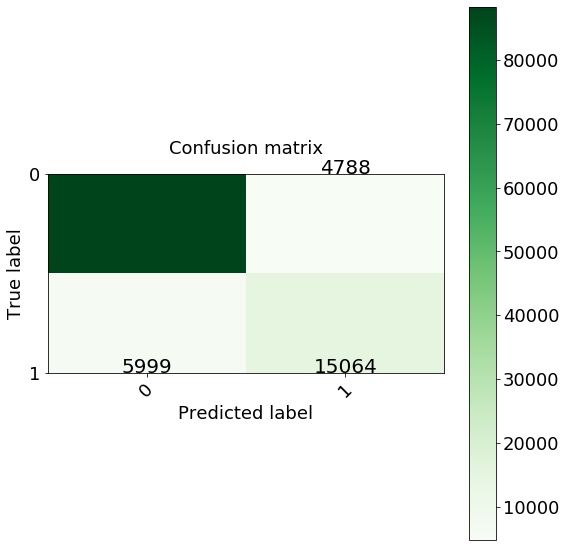

Normalized confusion matrix
[[0.95 0.05]
 [0.28 0.72]]


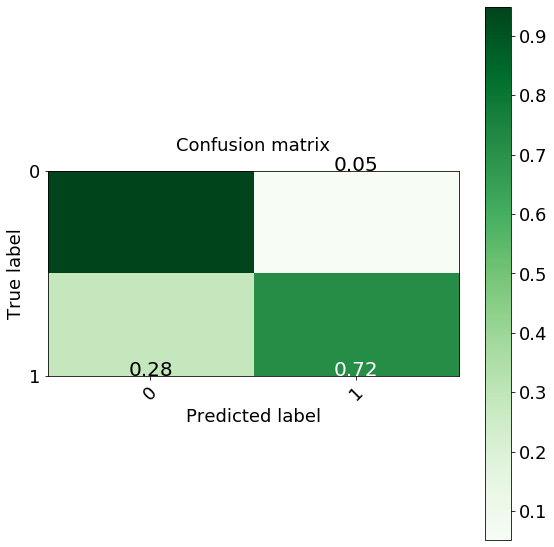

In [69]:
# Check custom metrics for threshold

y_test_pred = [1 if x[1]>0.3 else 0 for x in y_test_prob]

metrics(y_test,y_test_pred)

In [70]:
# Evaluate

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",
                                          labelCol="max_loan_stat",
                                          metricName='areaUnderROC')
auroc = evaluator.evaluate(predictions)

# confusion matrix
rm = (MulticlassMetrics(predictions.select("prediction", "max_loan_stat")
                        .rdd.map(lambda x: (float(x[0]), float(x[1])))))

print("AUROC:", auroc)
print("Confusion matrix:\n", rm.confusionMatrix().toArray())

AUROC: 0.857422867150478
Confusion matrix:
 [[89081.  4023.]
 [ 6366. 14697.]]


In [71]:
# Get feature importances

imp_list = []

for x, y in zip([x["name"] for x in sorted(train.schema["features_vec"].metadata["ml_attr"]["attrs"]["binary"]+
   train.schema["features_vec"].metadata["ml_attr"]["attrs"]["numeric"], 
   key=lambda x: x["idx"])],rf_model.featureImportances.toArray()):
    imp_list.append((x,y))
imp_df = pd.DataFrame(imp_list)
imp_df.columns = ['feature','importance']
imp_df = imp_df.set_index('feature')

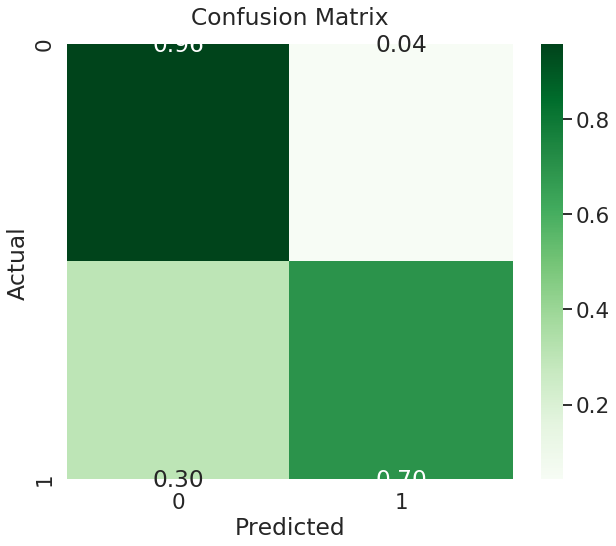

In [72]:
# Visualize the confusion matrix (Recall)

sns.set()

# Set style and context for font scaling
sns.set_style('darkgrid')
sns.set_context("talk", font_scale=1.3)

def display_cm(m,new_maps):
    a = m.toArray().astype(np.float)
    #print(a)
    #print(m)
    row_sums = a.sum(axis=1)
    percentage_matrix = a.astype(np.float) / row_sums[:,np.newaxis]
    #percentage_matrix =   100 *a.astype(np.float64) /a.astype(np.float64).sum(axis=1)
    #print(percentage_matrix)
    plt.figure(figsize=(10,8))
    sns.heatmap(percentage_matrix,annot=True,fmt='.2f',xticklabels=['0','1'],yticklabels=['0','1'],
                cmap=new_maps)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

display_cm(rm.confusionMatrix(),'Greens')

[[89081.  4023.]
 [ 6366. 14697.]]


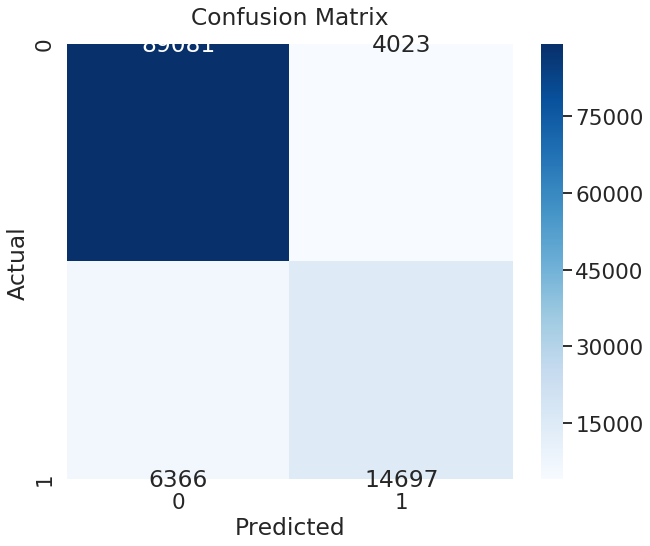

In [73]:
# Visualize the confusion matrix (counts)

sns.set()

# Set style and context for font scaling
sns.set_style('darkgrid')
sns.set_context("talk", font_scale=1.3)

def display_cm(m,new_maps):
    a = m.toArray().astype(np.float)
    print(a)
    row_sums = a.sum(axis=1)
    percentage_matrix = a.astype(np.float)
    #percentage_matrix =   100 *a.astype(np.float64) /a.astype(np.float64).sum(axis=1)
    plt.figure(figsize=(10,8))
    sns.heatmap(percentage_matrix,annot=True,fmt='.0f',xticklabels=['0','1'],yticklabels=['0','1'],
                cmap=new_maps)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

display_cm(rm.confusionMatrix(),'Blues')

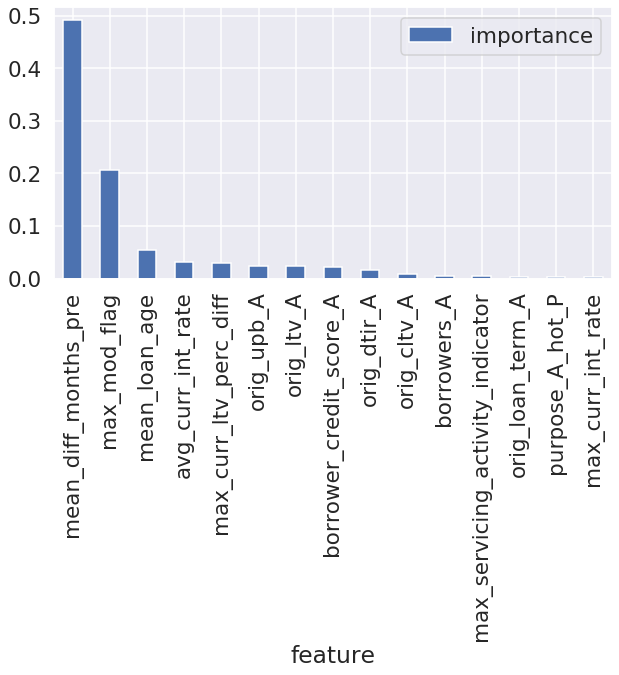

In [74]:
# Plot importance chart

imp_df.sort_values(by='importance',ascending=False)[:15].plot.bar(figsize=(10,5))

In [75]:
# F1 metrics

metrics = MulticlassMetrics(predictions.select("prediction", "max_loan_stat")
                             .rdd.map(lambda x: (float(x[0]),float(x[1]))))
for label in range(0,2):
    print('Label '+str(label)+' recall:',metrics.recall(label=label))
    print('Label '+str(label)+' precision:',metrics.precision(label=label))

    # label must be a Double or will fail. Beta=1 will give traditional F1. 
    print('Label '+str(label)+' f1:',metrics.fMeasure(label=float(label),beta=1.0))
    print('')

Label 0 recall: 0.9567902560577419
Label 0 precision: 0.9333032992131759
Label 0 f1: 0.9449008491071381

Label 1 recall: 0.6977638513032332
Label 1 precision: 0.7850961538461538
Label 1 f1: 0.7388583063117412



In [76]:
# Weighted stats

print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure(beta=1.0))
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Weighted recall = 0.9090017255424071
Weighted precision = 0.905960134350601
Weighted F(1) Score = 0.9068874645135214
Weighted F(0.5) Score = 0.9061780751763616
Weighted false positive rate = 0.25444761818143213


In [77]:
# End time
print('End time: ',datetime.datetime.now())

End time:  2019-09-20 22:57:26.138795


In [78]:
# Notes on experiments

# With one-hot encoding zip, results in vector size of 50736
# Takes about 15 minutes to run RFClassifier with numTrees=1, max depth=10
# Removal of max_MSA_hot reduces vector size from 50736 to around 996
# Further removal of zip_A_hot reduces vector size from 996 to 103

# Official End (Cleaned up code)